In [66]:
import becquerel as bq
import pandas as pd
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import math as m
import analysis_methods as am
import PF
import ROI

In [3]:
calibration = r'C:\Users\ahanks\spectra\E-calibration-Eu152.Spe'
spectrum1 = r'C:\Users\ahanks\spectra\shilling1642-8.Spe'
spectrum2 = r'C:\Users\ahanks\spectra\shilling-silver.Spe'
background = r'C:\Users\ahanks\spectra\background.Spe'

spec1 = Spectrum.from_file(spectrum1)
spec2 = Spectrum.from_file(spectrum2)
ecal = Spectrum.from_file(calibration)
bg = Spectrum.from_file(background)

SpeFile: Reading file C:\Users\ahanks\spectra\shilling1642-8.Spe
SpeFile: Reading file C:\Users\ahanks\spectra\shilling-silver.Spe
SpeFile: Reading file C:\Users\ahanks\spectra\E-calibration-Eu152.Spe
SpeFile: Reading file C:\Users\ahanks\spectra\background.Spe


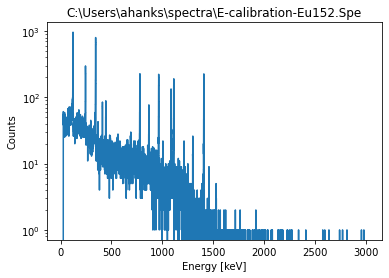

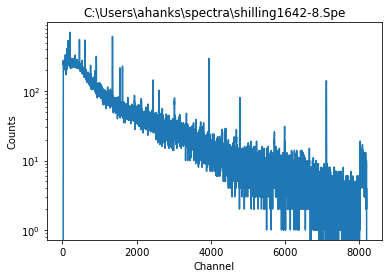

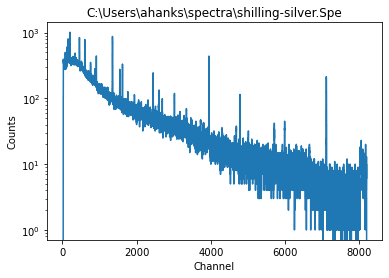

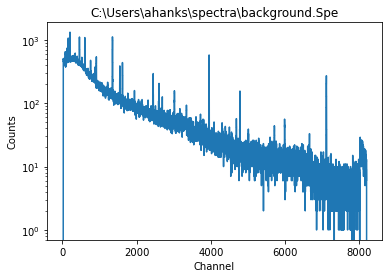

In [6]:
ecal.plot(yscale="log")
spec1.plot(yscale="log")
spec2.plot(yscale="log")
bg.plot(yscale="log")

In [16]:
if not spec1.is_calibrated:
    spec1.calibrate_like(ecal)
print(spec1.is_calibrated)
if not spec2.is_calibrated:
    spec2.calibrate_like(ecal)
print(spec2.is_calibrated)
if not bg.is_calibrated:
    bg.calibrate_like(ecal)
print(bg.is_calibrated)

True
True
True


C:\Users\ahanks\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)
C:\Users\ahanks\Anaconda3\lib\site-packages\becquerel-0.2.4-py3.7.egg\becquerel\core\spectrum.py:726: SpectrumWarning: Subtraction of counts-based specta, spectra have been converted to CPS
  'have been converted to CPS', SpectrumWarning)


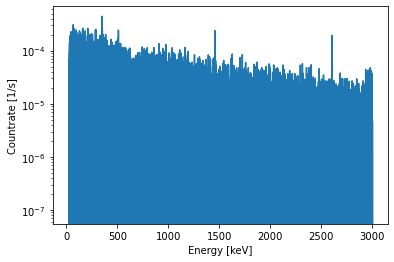

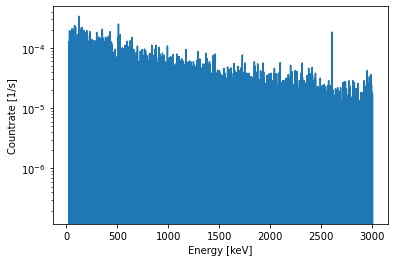

In [54]:
spec1_rebin = spec1.rebin(spec1.bin_edges_kev[0::4])
spec2_rebin = spec2.rebin(spec2.bin_edges_kev[0::4])
bg_rebin = bg.rebin(bg.bin_edges_kev[0::4])

spec1_sub = spec1 - bg
spec1_sub.plot(yscale="log")

spec2_sub = spec2- bg
spec2_sub.plot(yscale="log")

In [30]:
cps = spec1_sub.cps

In [39]:
cps[cps>0]

array([5.461526278133687e-06+/-6.166764201334653e-06,
       2.4996805194808726e-06+/-5.471521453343561e-05,
       6.954380997086645e-05+/-0.00011133548020375037, ...,
       3.743313219714443e-05+/-1.864100215750631e-05,
       4.66397452834231e-06+/-1.2981423100557431e-05,
       2.0661366809073625e-06+/-1.1423150397365144e-05], dtype=object)

In [50]:
def get_energies(spec):
    kernel = bq.GaussianPeakFilter(4250,30, fwhm_at_0=10)
    finder = bq.PeakFinder(spec, kernel)
    plt.figure()
    plt.plot(spec.counts_vals.clip(1e-1), label='Raw spectrum')
    plt.plot(finder._peak_plus_bkg.clip(1e-1), label='Peaks+Continuum')
    plt.plot(finder._bkg.clip(1e-1), label='Continuum')
    plt.plot(finder._signal.clip(1e-1), label='Peaks')
    plt.yscale('log')
    plt.xlim(0, len(spec))
    plt.ylim(3e-1)
    plt.xlabel('Channels')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()
    
    finder.reset()
    finder.find_peaks(min_snr=8, xmin=50)

    plt.figure()
    plt.title('find_peaks')
    finder.plot()
    plt.tight_layout()
    
    energies = np.take(spec.bin_edges_kev,finder.centroids)
    #print(finder.centroids)
    print(energies)
    return energies

[  45.65296097   62.46693227   74.16348756   83.66686599   91.70813527
  184.9103493   237.53941637  294.18652392  350.83131374  509.7897958
  581.77188443  607.71374982  909.8458527   966.83072677 1118.77891316
 1458.77554186 1762.54710372 2201.65640811 2611.07391923]


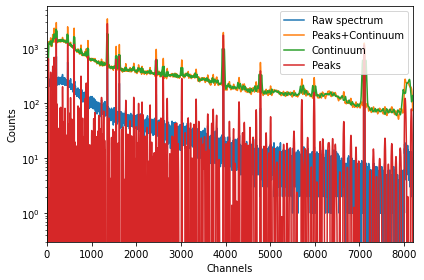

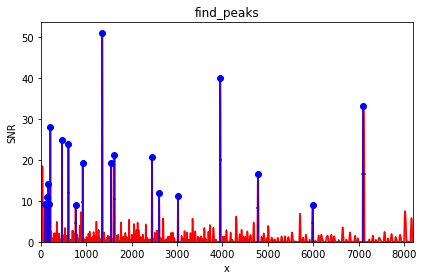

In [51]:
spec1_energies = get_energies(spec1)

[  45.28743759   62.46693227   73.7979717    84.03237925   91.70813527
  184.9103493   237.53941637  294.18652392  337.30986483  350.83131374
  509.7897958   581.77188443  608.07912473  726.09017357  909.8458527
  966.83072677  999.70554771 1118.77891316 1236.01598205 1459.14069199
 1762.54710372 2101.29044796 2201.2914542  2611.07391923 2947.05582161]


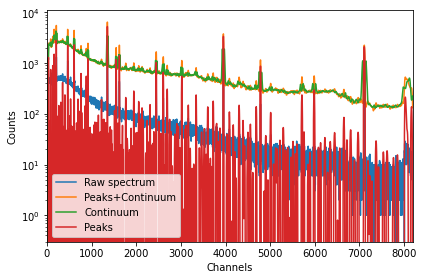

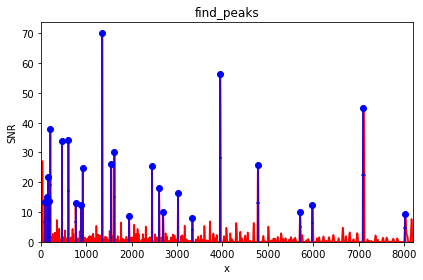

In [52]:
bg_energies = get_energies(bg)

[  45.28743759   62.46693227   73.7979717    84.03237925   91.70813527
  184.9103493   237.53941637  294.18652392  337.30986483  350.83131374
  509.7897958   581.77188443  608.07912473  909.8458527   966.83072677
  999.34027622 1118.41367311 1459.14069199 1762.91217359 2100.92546751
 2201.65640811 2610.70907356 2947.78533496]


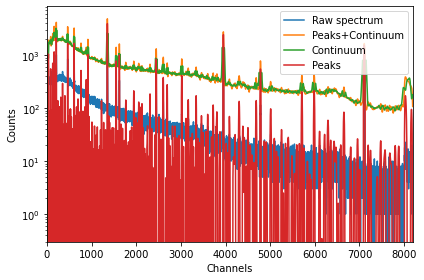

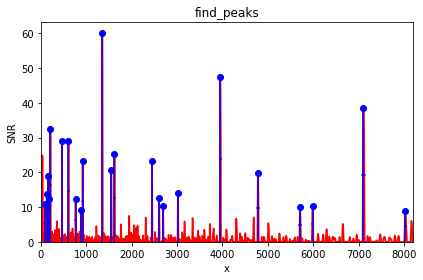

In [53]:
spec2_energies = get_energies(spec2)

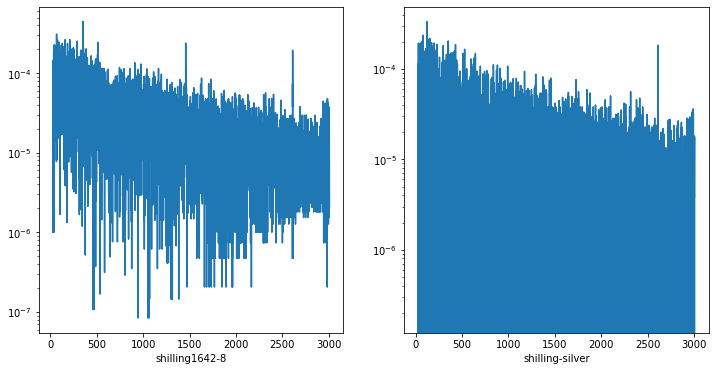

In [57]:
energies1 = spec1_sub.bin_centers_kev[cps>0]
cps_vals1 = spec1_sub.cps_vals[cps>0]

energies2 = spec2_sub.bin_centers_kev[cps>0]
cps_vals2 = spec2_sub.cps_vals[cps>0]

fig = plt.figure(1, figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(energies1,cps_vals1)
ax1.set_xlabel('shilling1642-8')
ax1.set_yscale('log')

ax2.plot(energies2,cps_vals2)
ax2.set_xlabel('shilling-silver')
ax2.set_yscale('log')


In [59]:
peak_counts, uncertainties = am.get_counts(spec1,bg,spec1_energies)

In [92]:
roi = ROI.ROI(spec1,bg,spec1_energies,1)
roi_counts, roi_unc = roi.get_counts()
roi_counts = np.array(roi_counts)
roi_unc = np.array(roi_unc)

In [74]:
import plotly.graph_objects as go

In [80]:
data = [
        go.Scatter(
            x=spec1_energies, 
            y=roi_counts,
            error_y=dict(
                type='data',
                symmetric=True,
                array=roi_unc),            
            name="shilling1642-8",
            mode='markers'
        ),
]
fig = go.Figure(data)
fig.update_yaxes(title="Counts",titlefont=dict(size=16))
fig.update_yaxes(range=[0, 250])
fig.update_xaxes(title='Energy [keV]',titlefont=dict(size=16))
fig.show()

In [93]:
roi2 = ROI.ROI(spec2,bg,spec2_energies,1)
roi_counts2, roi_unc2 = roi2.get_counts()
roi_counts2 = np.array(roi_counts2)
roi_unc2 = np.array(roi_unc2)

In [83]:
data = [
        go.Scatter(
            x=spec2_energies, 
            y=roi_counts2,
            error_y=dict(
                type='data',
                symmetric=True,
                array=roi_unc2),            
            name="shilling1642-8",
            mode='markers'
        ),
]
fig = go.Figure(data)
fig.update_yaxes(title="Counts",titlefont=dict(size=16))
fig.update_yaxes(range=[0, 250])
fig.update_xaxes(title='Energies [keV]',titlefont=dict(size=16))
fig.show()

In [96]:
mask1 = (roi_counts-roi_unc)>0
mask2 = (roi_counts2-roi_unc2)>0

data = [
        go.Scatter(
            x=spec1_energies[mask1], 
            y=roi_counts[mask1],
            error_y=dict(
                type='data',
                symmetric=True,
                array=roi_unc[mask1]),
            name="shilling1642-8",
            mode='markers'
        ),
        go.Scatter(
            x=spec2_energies[mask2],
            y=roi_counts2[mask2],
            error_y=dict(
                type='data',
                symmetric=True,
                array=roi_unc2[mask2]),
            name="shilling-silver",
            mode='markers'
        ),
]
fig = go.Figure(data)
fig.update_yaxes(title="Counts",titlefont=dict(size=16))
fig.update_yaxes(range=[0, 280])
fig.update_xaxes(title='Energies [keV]',titlefont=dict(size=16))
fig.show()

In [101]:
from becquerel.tools import nndc

In [117]:
energies1 = spec1_energies[mask1]
nndc_info = []
hl_cut = 3600*24*365*2
for i in range(len(energies1)):
    energy_range = [energies1[i]-5, energies1[i]+10]
    info = nndc.fetch_decay_radiation(t_range=(hl_cut, None), 
                                      i_range=(1, None), 
                                      type='Gamma', 
                                      e_range=energy_range)
    nndc_info.append(info)

In [118]:
nndc_info[0]

,Z,Element,A,m,M,N,JPi,Energy Level (MeV),Decay Mode,Radiation,Radiation subtype,Radiation Energy (keV),Radiation Intensity (%),T1/2 (txt),T1/2 (s),Daughter,Endpoint Energy (keV),Dose (MeV / Bq / s)
0,22,TI,44,,0,22,0+,0,EC,G,,67.8679+/-0.0014,93.0+/-2.0,59.1 Y 3,1.865000e+09,44SC,None,0.0631+/-0.0013
1,26,FE,60,,0,34,0+,0,B-,G,,58.603+/-0.007,2.0652,2.62E+6 Y 4,8.268000e+13,60CO,None,0.0012103
2,50,SN,126,,0,76,0+,0,B-,G,,64.281+/-0.010,9.6+/-1.5,2.30E+5 Y 14,7.258000e+12,126SB,None,0.0062+/-0.0010
3,61,PM,145,,0,84,5/2+,0,EC,G,,72.40+/-0.10,2.2,17.7 Y 4,5.586000e+08,145ND,None,0.00159
4,63,EU,155,,0,92,5/2+,0,B-,G,,60.0089+/-0.0010,1.170+/-0.030,4.753 Y 14,1.500000e+08,155GD,None,0.000700+/-0.000020
5,71,LU,174,,0,103,(1)-,0,EC,G,XR kb3,59.159,4.50+/-0.30,3.31 Y 5,1.044600e+08,174YB,None,0.00269+/-0.00016
6,71,LU,174,,0,103,(1)-,0,EC,G,XR kb1,59.383,8.8+/-0.5,3.31 Y 5,1.044600e+08,174YB,None,0.00520+/-0.00030
7,71,LU,174,,0,103,(1)-,0,EC,G,XR kb2,60.962,2.96+/-0.17,3.31 Y 5,1.044600e+08,174YB,None,0.00181+/-0.00011
8,71,LU,176,,0,105,7-,0,B-,G,XR kb3,62.985,1.86+/-0.06,3.76E10 Y 7,1.187000e+18,176HF,None,0.00117+/-0.00004
9,71,LU,176,,0,105,7-,0,B-,G,XR kb1,63.243,3.59+/-0.11,3.76E10 Y 7,1.187000e+18,176HF,None,0.00227+/-0.00007


In [119]:
nndc_info[1]

,Z,Element,A,m,M,N,JPi,Energy Level (MeV),Decay Mode,Radiation,Radiation subtype,Radiation Energy (keV),Radiation Intensity (%),T1/2 (txt),T1/2 (s),Daughter,Endpoint Energy (keV),Dose (MeV / Bq / s)
0,56,BA,133,,0,77,1/2+,0.0,EC,G,,356.0129+/-0.0007,62.05,10.551 Y 11,3.330000e+08,133CS,None,0.2209
1,96,CM,247,,0,151,9/2-,0.0,A,G,,346.0+/-0.8,1.30+/-0.13,1.56E+7 Y 5,4.923000e+14,243PU,None,0.0045+/-0.0004


In [121]:
nndc_info[2]

,Z,Element,A,m,M,N,JPi,Energy Level (MeV),Decay Mode,Radiation,Radiation subtype,Radiation Energy (keV),Radiation Intensity (%),T1/2 (txt),T1/2 (s),Daughter,Endpoint Energy (keV),Dose (MeV / Bq / s)


In [122]:
nndc_info[3]

,Z,Element,A,m,M,N,JPi,Energy Level (MeV),Decay Mode,Radiation,Radiation subtype,Radiation Energy (keV),Radiation Intensity (%),T1/2 (txt),T1/2 (s),Daughter,Endpoint Energy (keV),Dose (MeV / Bq / s)
0,83,BI,208,,0,125,5+,0.0,EC,G,,2614.5,99.785,3.68E+5 Y 4,1.161000e+13,208PB,None,2.609
